In [1]:
import statsmodels.nonparametric.smoothers_lowess as lowess

In [2]:
with open("scaffolds.txt", "r") as fh:
    scafs = [line.strip() for line in fh]

In [187]:
dat = pd.DataFrame()
for scaf in scafs:
    df = pd.read_csv(f"PRDM9_All_Top50k_copy/{scaf}_PRDM9_All_Top50k_closest.bed", sep="\t")
    df.columns = ["scaf", "start", "end", "rrate", "scaf", "start2", "end2", "buh", "alleles", "distance"]
    df["kind"] = "prdm9"
    df2 = pd.read_csv(f"PRDM9_All_Top50k_copy/{scaf}_Promoters_closest.bed", sep="\t")
    df2.columns = ["scaf", "start", "end", "rrate", "scaf", "start2", "end2", "buh", "alleles", "distance"]
    df2["kind"] = "promoters"
    dat = pd.concat([dat, df, df2])

FileNotFoundError: [Errno 2] No such file or directory: 'PRDM9_All_Top50k_copy/Super_scaffold_106_Promoters_closest.bed'

In [113]:
#dat["qdistance"] = pd.qcut(dat['distance'], q=30, duplicates="drop")
dat["qdistance"] = pd.Interval(-1, 0)
dat.loc[dat['distance'] == 0, 'qdistance'] = pd.Interval(-1, 0)
dat.loc[dat['distance'] != 0, 'qdistance'] = pd.qcut(dat.loc[dat['distance'] != 0, 'distance'], q=10)

In [114]:
results_l = []
for dist,df in dat.groupby("qdistance"):
    mean = df["rrate"].mean()
    rates = list(df["rrate"].values)
    means = []
    for rep in range(200):
        rep_mean = np.mean(np.random.choice(rates, size=len(rates), replace=True))
        means.append(rep_mean)
    low_ci = np.percentile(means, 2.5)
    high_ci = np.percentile(means, 97.5)
    results_l.append([dist, mean, low_ci, high_ci])

In [115]:
results = pd.DataFrame(results_l)
results.columns = ["distance", "mean", "low_ci", "high_ci"]

In [179]:
tail_rate = dat[dat.distance.between(10e3,12e3)]["rrate"].mean()

In [180]:
for c in ["mean", "low_ci", "high_ci"]:
    results[f"norm_{c}"] = results[c]/tail_rate

In [181]:
results["midpoint"] = [d.mid for d in results.distance]

In [182]:
results

,distance,mean,low_ci,high_ci,norm_mean,norm_low_ci,norm_high_ci,midpoint
0,"(-1.0, 0.0]",0.006277,0.006216,0.006347,1.770208,1.753050,1.789928,-0.5000
1,"(0.999, 156.0]",0.005783,0.005733,0.005820,1.631000,1.616790,1.641337,78.4995
2,"(156.0, 331.0]",0.005665,0.005615,0.005717,1.597714,1.583533,1.612251,243.5000
3,"(331.0, 531.0]",0.005558,0.005508,0.005615,1.567661,1.553296,1.583721,431.0000
4,"(531.0, 763.0]",0.005349,0.005312,0.005392,1.508518,1.498104,1.520731,647.0000
5,"(763.0, 1039.0]",0.005171,0.005129,0.005217,1.458284,1.446504,1.471400,901.0000
6,"(1039.0, 1378.0]",0.004985,0.004936,0.005031,1.405917,1.392057,1.418946,1208.5000
7,"(1378.0, 1820.0]",0.004810,0.004755,0.004863,1.356633,1.340956,1.371536,1599.0000
8,"(1820.0, 2449.0]",0.004573,0.004533,0.004617,1.289697,1.278523,1.302253,2134.5000
9,"(2449.0, 3539.0]",0.004376,0.004328,0.004427,1.234236,1.220672,1.248565,2994.0000


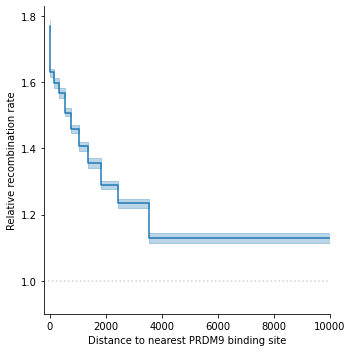

In [183]:
f,ax = plt.subplots(figsize=[5,5])

xs = results["distance"].apply(lambda x: x.right)
ax.step(xs, results["norm_mean"])

for i,r in results.iterrows():
    xs = [r.distance.left, r.distance.right+0.5]
    ys = [r.norm_mean, r.norm_mean]
    
    # Use step plot instead of line plot
    #ax.step(xs, ys, where='post', color="C0")
    #m = r.norm_mean
    #ax.plot(xs, ys, color="C0")
    ax.fill_between(xs, r["norm_low_ci"], r["norm_high_ci"], alpha=0.3, color="C0")

ax.axhline(y=1, linestyle="dotted", color="lightgray")
ax.set_ylabel("Relative recombination rate")
ax.set_xlabel("Distance to nearest PRDM9 binding site")

ax.set_xlim([-200, 10e3])
ax.set_ylim(bottom=0.9)
sns.despine()
plt.tight_layout()
#plt.savefig("equally_sized_bins_islands.pdf")
#sns.lineplot(data=results, 
#             x="midpoint", 
#             y="norm_mean",
#             ax=ax)

(0.0, 6.0)

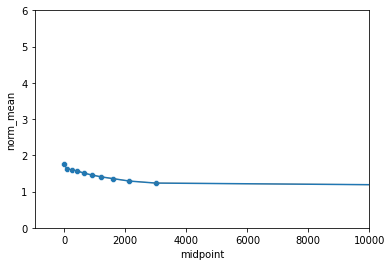

In [186]:
f,ax = plt.subplots()
sns.lineplot(data=results, 
             x="midpoint", 
             y="norm_mean",
             ax=ax)
sns.scatterplot(data=results, 
                x="midpoint", 
                y="norm_mean",
                ax=ax)
ax.fill_between(results.midpoint, 
                results.norm_low_ci, 
                results.norm_high_ci, 
                alpha=0.6)
ax.set_xlim(right=10e3)
ax.set_ylim([0,6])

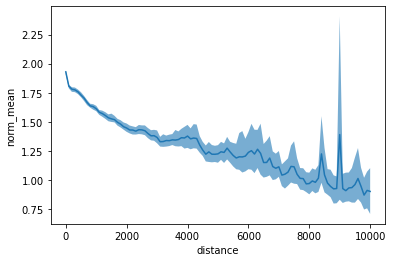

In [144]:
f,ax = plt.subplots()
sns.lineplot(data=results, 
             x="distance", 
             y="norm_mean",
             ax=ax)
ax.fill_between(results.distance, 
                results.norm_low_ci, 
                results.norm_high_ci, 
                alpha=0.6)

In [73]:
import pickle

In [95]:
with open("PRDM9_All_Top50k_copy/_all_Means_dict.txt", "rb") as f:
    means = pickle.load(f)
with open("PRDM9_All_Top50k_copy/_all_Boots_dict.txt", "rb") as f:
    boots = pickle.load(f)

In [103]:
for k,v in boots.items():
    low_ci = np.percentile(v, 2.5)
    high_ci = np.percentile(v, 97.5)
    if k==0:
        print(k, low_ci, high_ci)

0 0.006065061854289646 0.006183221078108386


In [167]:
smoothed_values = np.empty((len(boots[0]), 101))
for count in range(len(boots[0])): 
    x = []
    y = []
    for dis in sorted(boots): 
        if dis > 10000: continue
        x.append(dis)
        y.append(boots[dis][count])
    #Smooth the bootstrapped values for this run
    smoothed_values[count] = lowess.lowess(y, x, frac=.1, it=3, return_sorted = False)
#Sort each column
sorted_values = np.sort(smoothed_values, axis=0)
#Find the confidence intervals for each distance
bound = int(len(boots[0]) * (1 - .95) / 2)
bottom = sorted_values[bound-1]
top = sorted_values[-bound]
m = lowess.lowess(carla["mean"], carla.distance, frac=.1, it=3, return_sorted = False)

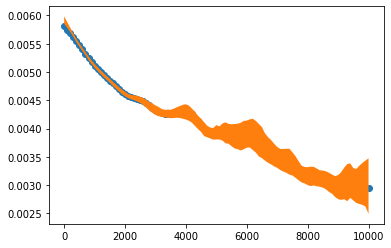

In [171]:
plt.scatter(carla.distance, m)
plt.fill_between(carla.distance, bottom, top)

In [83]:
carla = pd.DataFrame([means.keys(), means.values()]).transpose()
carla.columns = ["distance", "mean"]

In [86]:
carla = carla.sort_values(by="distance").reset_index(drop=True)

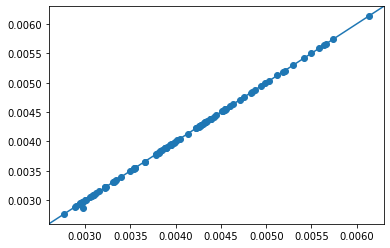

In [92]:
plt.scatter(carla["mean"], results["mean"])
plt.axline((0.003,0.003),slope=1)